In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

In [ ]:
import os
import cv2
import shutil

In [ ]:
print("total:",len(os.listdir('/content/PetImages/Dog')))
!mkdir ./dataset ./dataset/train ./dataset/test ./dataset/train/original ./dataset/train/upside_down ./dataset/test/original ./dataset/test/upside_down
!mv ./PetImages/Dog/* ./dataset/train/original
tests = os.listdir("/content/dataset/train/original")
for test in tests[:2500]:
  shutil.move("/content/dataset/train/original/" + test, "/content/dataset/test/original/" + test)
print("train:",len(os.listdir('./dataset/train/original')))
print("test:",len(os.listdir('./dataset/test/original')))

total: 12501
train: 10001
test: 2500


In [ ]:
def rm_errors(path, errors):
  for error in errors:
    os.remove(path+error)

In [ ]:
def rotate(source, destination):
#   source = '/content/dataset/train/original/'
#   destination = '/content/dataset/train/upside_down/'

    dogs = os.listdir(source)
    errors = []
    for dog in dogs:
        image_path = os.path.join(source,dog)
        img = cv2.imread(image_path)
        img = cv2.rotate(img,cv2.ROTATE_180)
        try:
          img_save = cv2.imwrite(destination+dog,img)
        except:
          errors.append(dog)
    print("save Successfully")
    print(f"number of errors: {len(errors)}")
    print(f"total number:", len(os.listdir(destination)))
    rm_errors(source, errors)

In [ ]:
train_source = "/content/dataset/train/original/"
train_dest = "/content/dataset/train/upside_down/"
test_source = "/content/dataset/test/original/"
test_dest = "/content/dataset/test/upside_down/"
rotate(train_source, train_dest)
rotate(test_source, test_dest)

save Successfully
number of errors: ['7112.jpg', '7459.jpg', '6718.jpg', '7133.jpg', '10747.jpg', '1308.jpg', '6059.jpg', '9188.jpg', 'Thumbs.db', '2877.jpg', '7369.jpg', '10158.jpg', '3288.jpg', '10401.jpg', '3588.jpg', '1866.jpg', '2384.jpg', '11702.jpg', '4367.jpg', '7969.jpg', '11410.jpg', '11849.jpg', '5604.jpg', '8730.jpg']
total number: 9977
save Successfully
number of errors: ['3136.jpg', '10797.jpg', '2688.jpg', '11853.jpg', '11675.jpg', '5736.jpg', '6238.jpg']
total number: 2493


In [ ]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 5.0 MB/s 


In [ ]:
import efficientnet.tfkeras as efn

In [ ]:
import tensorflow as tf 
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
train_dir = "/content/dataset/train/"
test_dir = "/content/dataset/test/"

train_datagen = ImageDataGenerator(rescale = 1./255.)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

batch_size = 64

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = batch_size, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory(test_dir, batch_size = batch_size, class_mode = 'binary', target_size = (224, 224))

Found 19954 images belonging to 2 classes.
Found 4986 images belonging to 2 classes.


In [ ]:
def init_model():
  base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
  # base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

  for layer in base_model.layers:
    layer.trainable = False

# drop out: 0.2, 0.3, 0.5
  x = base_model.output
  x = Flatten()(x)
  x = Dense(1024, activation="relu")(x)
  x = Dropout(0.3)(x)
  x = Dense(512, activation="relu")(x)
  x = Dropout(0.3)(x)
  predictions = Dense(1, activation="sigmoid")(x)
  model = Model(base_model.input, predictions)
  return model

In [ ]:
model = init_model()

In [ ]:
checkpoint = ModelCheckpoint("upside_down3.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

# we put our call backs into a callback list
callbacks = [checkpoint]

model.compile(RMSprop(lr=0.001),loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_generator, validation_data = validation_generator, callbacks=callbacks, epochs = 10)

Epoch 1/10
243/312 [======================>.......] - ETA: 24s - loss: 0.8286 - accuracy: 0.9446

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

312/312 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.9487
Epoch 1: val_loss improved from inf to 0.09268, saving model to upside_down2.h5
312/312 [==============================] - 145s 441ms/step - loss: 0.6800 - accuracy: 0.9487 - val_loss: 0.0927 - val_accuracy: 0.9721
Epoch 2/10
312/312 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.9733
Epoch 2: val_loss did not improve from 0.09268
312/312 [==============================] - 125s 400ms/step - loss: 0.1459 - accuracy: 0.9733 - val_loss: 0.1421 - val_accuracy: 0.9781
Epoch 3/10
312/312 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.9810
Epoch 3: val_loss did not improve from 0.09268
312/312 [==============================] - 125s 401ms/step - loss: 0.1191 - accuracy: 0.9810 - val_loss: 0.1397 - val_accuracy: 0.9785
Epoch 4/10
312/312 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9853
Epoch 4: val_loss did not improve from 0.09268
3

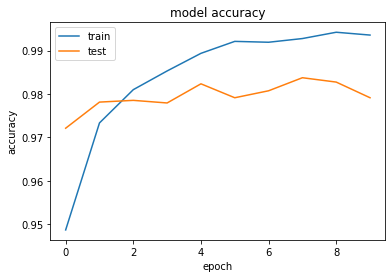

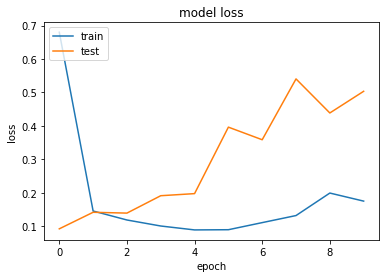

In [ ]:
# drop out 0.2
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

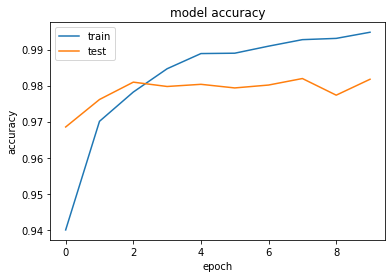

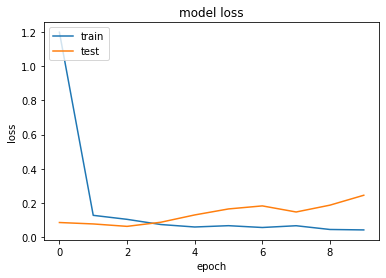

In [ ]:
# drop out 0.3
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

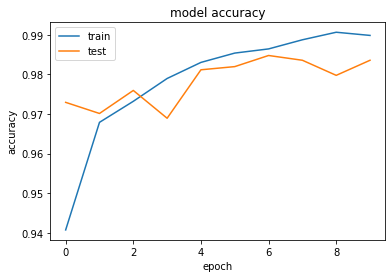

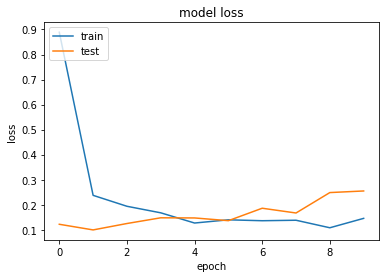

In [ ]:
# drop out 0.5
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = tf.keras.models.load_model('upside_down3.h5')

In [ ]:
loss, acc = model.evaluate_generator(validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
# 0.2
acc, loss

(0.9767348766326904, 0.07668403536081314)

In [ ]:
# 0.3
acc, loss

(0.9809466600418091, 0.06333416700363159)

In [ ]:
# 0.5
acc, loss

(0.9765343070030212, 0.09238456934690475)